In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from fastai.vision.all import *

In [12]:
from fastai.utils.mem import *

ModuleNotFoundError: No module named 'fastai.utils'

In [4]:
def is_unfreeze(learner):
    '''
    Determines whether the next-to-last layer in the model is set to unfreeze or freeze
    '''
    c = 0
    for each in list(learner.model[-2][0].parameters()):
        if each.requires_grad: c += 1   
    if c == len(list(learner.model[-2][0].parameters())):
        return True 
    else:
        return False



def find_optimal_lr(learner, noise=3, show_df=None, show_min_values=False):
    loss = np.array(learner.recorder.losses)
    loss_grad = np.gradient(loss)   
    # Transform lrs list to np array
    lrs = np.array(learner.recorder.lrs, dtype='float32')

    # Create a DataFrame with the data
    data = {'loss': loss.T, 'loss_grad': loss_grad.T, 'lrs': lrs.T}
    df = pd.DataFrame(data, columns=['loss', 'loss_grad', 'lrs', 'min_loss', 'max_loss', 'min_grad', 'max_grad'])

    # Populate "min" and "max" columns for loss and gradient values filtering the noise with argrelextrema.     
    from scipy.signal import argrelextrema

    #********
    # IMPORTANT: n filters noise (sharp spikes in the data). Higher n value filters noise more aggressively. 
    # n = 3 seems to work best
    n=noise    
    #********

    df.min_loss = df.iloc[argrelextrema(df.loss.values, np.less_equal, order=n)[0]]['loss']
    df.max_loss = df.iloc[argrelextrema(df.loss.values, np.greater_equal, order=n)[0]]['loss']
    df.min_grad = df.iloc[argrelextrema(df.loss_grad.values, np.less_equal, order=n)[0]]['loss_grad']
    df.max_grad = df.iloc[argrelextrema(df.loss_grad.values, np.greater_equal, order=n)[0]]['loss_grad']

    # Optional: Display dataframe if show_df=True
    if show_df == 'head': print(df.head(50)) 
    elif show_df == 'tail': print(df.tail(50))     

    # Plot losses and loss gradients against lr values
    plt.figure(figsize=[8, 5])
    #figs, ax = plt.subplots(1,1)
    ax = plt.gca()
    color_loss = 'blue'
    color_grad = 'orange'
    color_green = 'green'
    color_red = 'red'

    ax.xaxis.grid(True)
    ax.set_ylabel('Loss')
    ax.set_title('Learn Rate Finder')
    ax.tick_params(axis='y', labelcolor=color_loss)
    ax.semilogx(df.lrs, df.loss, c=color_loss, label='loss')

    # Define variable vertical size of the plot window, depending on the graph shape
    u_limit = max(df.loss.loc[(df.lrs < 0.1)].max(), 250)*2    
    ax.set_ylim([-200, u_limit])

    # Plot resulting line graphs
    ax2 = ax.twinx()
    ax2.set_ylabel('loss', color= color_grad)
    ax2.semilogx(df.lrs, df.loss_grad, c = color_grad, label='loss_grad')
    ax2.tick_params(axis='y', labelcolor = color_grad)

    # plot inflection points
    ax.scatter(df.lrs, df.min_loss, c = color_red, label='min_loss')    
    ax2.scatter(df.lrs, df.min_grad, c = color_red, label='min_grad')    
    if show_min_values:
     ax.scatter(df.lrs, df.max_loss, c = color_green, label='max_loss')
     ax2.scatter(df.lrs, df.max_grad, c = color_green, label='max_grad') 

    # Legends
    plt.LogFormatter(labelOnlyBase=False)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.0), ncol=3, fancybox=True, shadow=True)
    ax2.legend(loc='upper center', bbox_to_anchor=(0.5, 0.9), ncol=3, fancybox=True, shadow=True)
    plt.show()

    # Display resulting lr values, format varies depending of te state of the model's next-to-last layer ggroup: set to freeze or unfreeze    
    if is_unfreeze(learner):
     # Yellow min_grad graph
     rev_tru_idx = df.min_grad.notna()[::-1]   
     optimun_lr_upper_bound_g = df.lrs.iloc[rev_tru_idx.idxmax()] 
     rev_tru_idx[rev_tru_idx.idxmax()] = np.NaN      
     optimun_lr_lower_bound_1_g = df.lrs.iloc[rev_tru_idx.idxmax()]
     rev_tru_idx[rev_tru_idx.idxmax()] = np.NaN      
     optimun_lr_lower_bound_2_g = df.lrs.iloc[rev_tru_idx.idxmax()] 

     # Blue lass graph
     rev_tru_idx_loss = df.min_loss.notna()[::-1]   
     optimun_lr_upper_bound_l = df.lrs.iloc[rev_tru_idx_loss.idxmax()] 
     rev_tru_idx_loss[rev_tru_idx_loss.idxmax()] = np.NaN      
     optimun_lr_lower_bound_1_l = df.lrs.iloc[rev_tru_idx_loss.idxmax()]
     rev_tru_idx_loss[rev_tru_idx_loss.idxmax()] = np.NaN      
     optimun_lr_lower_bound_2_l = df.lrs.iloc[rev_tru_idx_loss.idxmax()] 

     # Print results and return choices of lr slice
     print('Model set to: "unfreeze" or "freeze_to:"')      
     data = {'*Gradient - Orange Graph*' : [optimun_lr_upper_bound_g, optimun_lr_lower_bound_1_g, optimun_lr_lower_bound_2_g], 
          '*Loss - Blue Graph*' : [optimun_lr_upper_bound_l, optimun_lr_lower_bound_1_l, optimun_lr_lower_bound_2_l]}
     prdf = pd.DataFrame(data, index = ['First choice lr:', 'Second choice lr:', 'Third choice lr:' ])
     pd.options.display.float_format = '{:.10E}'.format

     print(prdf)

     return optimun_lr_lower_bound_1_g, optimun_lr_upper_bound_g

    else:

     optimun_lr_upper_bound = df.lrs.iloc[df.min_grad.notna()[::-1].idxmax()]
     optimun_lr_lower_bound = df.lrs.iloc[df.min_loss.notna()[::-1].idxmax()]/10
     # Print results and return optimal lr
     print('Model set to "freeze":')
     print('  Optimun lr: {:.10E} '.format(optimun_lr_upper_bound))
     print('  Min loss divided by 10: {:.10E}'.format(optimun_lr_lower_bound))
     return optimun_lr_upper_bound 

In [5]:
path=untar_data(URLs.CAMVID)

NameError: name 'untar_data' is not defined

In [6]:
path.ls()

NameError: name 'path' is not defined

In [7]:
label_names=get_image_files(path/'labels')

NameError: name 'get_image_files' is not defined

In [8]:
len(label_names)

NameError: name 'label_names' is not defined

In [9]:
images_names=get_image_files(path/'images')

NameError: name 'get_image_files' is not defined

In [10]:
len(images_names)

NameError: name 'images_names' is not defined

In [ ]:
open_image(path/'images'/images_names[0],)

In [41]:
def get_image_mask(file_name):
    """returns path of fianl label mask acc to passed file name"""
    return 

In [46]:
get_image_mask = lambda x: path/'labels'/f'{x.stem}_P{x.suffix}'

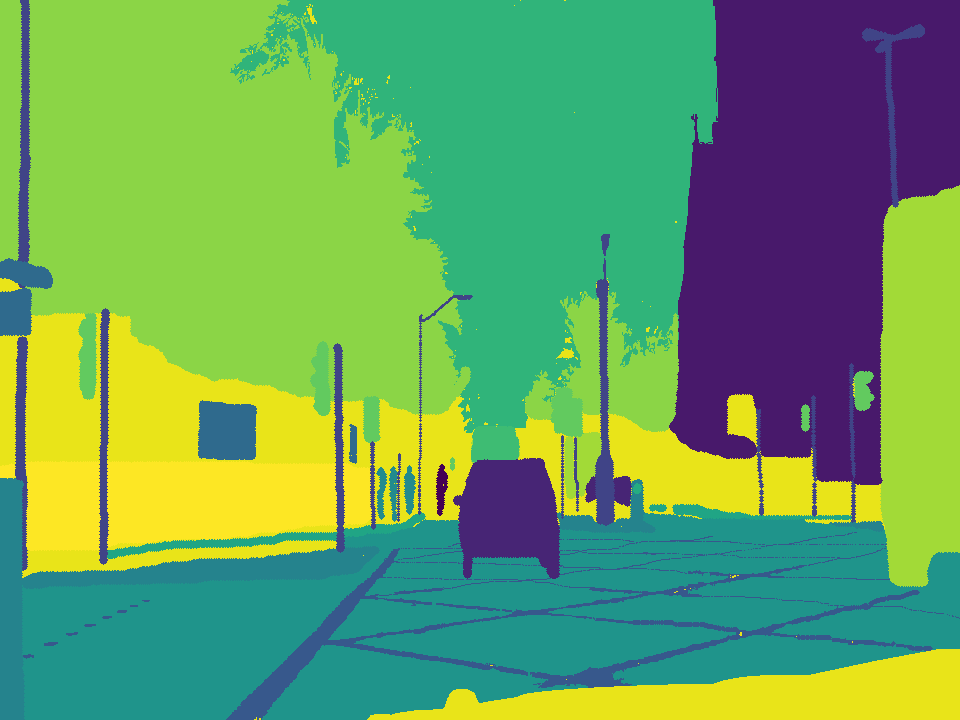

In [32]:
open_mask(get_image_mask(images_names[0]))

In [40]:
codes=np.loadtxt(path/'codes.txt',dtype=str)

In [49]:
path

PosixPath('/storage/camvid')

In [54]:
free = gpu_mem_get_free_no_cache()

if free > 8200: 
    bs=8
else:
    bs=4

In [57]:
data= (SegmentationItemList.from_folder(path/'images')
       .split_by_rand_pct(.3)
      .label_from_func(get_image_mask,classes=codes)
      .transform(get_transforms(),tfm_y=True,size=128)
      .databunch(bs=bs)
      .normalize(imagenet_stats)
      )

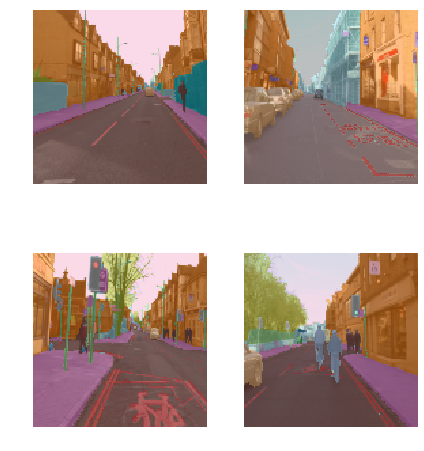

In [51]:
data.show_batch(rows=2, figsize=(6,7))

In [126]:
codes=np.loadtxt(path/'codes.txt',dtype=str)

In [127]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [129]:
learn=unet_learner(data,models.resnet34,metrics=acc_camvid)

In [130]:
learn.lr_find()

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.75E-04
Min loss divided by 10: 2.75E-03


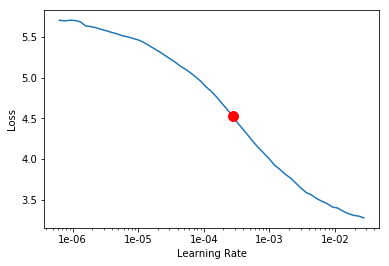

In [131]:
learn.recorder.plot(suggestion=True)

In [132]:
learn.fit_one_cycle(16,2.75E-04)

epoch,train_loss,valid_loss,acc_camvid,time
0,2.074475,1.325761,0.680532,00:20
1,1.058628,0.844687,0.800704,00:20
2,0.820334,0.684070,0.827752,00:20
3,0.730222,0.627516,0.842585,00:20
4,0.617380,0.563271,0.852957,00:20
5,0.572731,0.521162,0.869693,00:20
6,0.540118,0.568254,0.849429,00:20
7,0.496502,0.448932,0.881546,00:20
8,0.459379,0.433722,0.883825,00:20
9,0.437804,0.430155,0.882053,00:20


In [133]:
learn.fit_one_cycle(3,2.75E-04)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.427402,0.444587,0.881657,00:20
1,0.418460,0.387785,0.893365,00:20
2,0.361618,0.364407,0.899264,00:20


In [134]:
learn.save('stage-1')

In [135]:
learn.unfreeze()

In [136]:
learn.lr_find()

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.75E-04
Min loss divided by 10: 1.10E-07


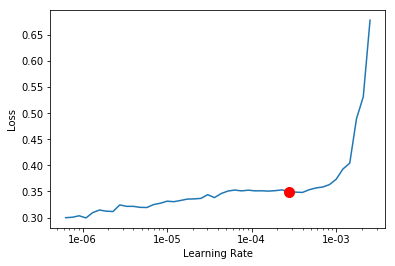

In [142]:
learn.recorder.plot(suggestion=True)

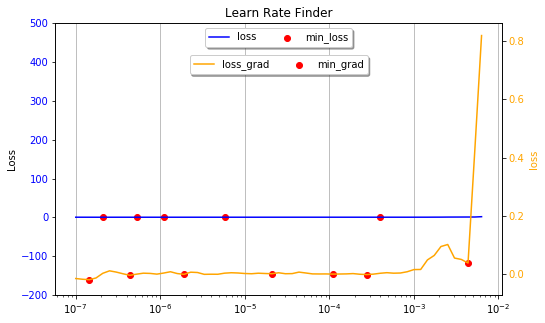

Model set to: "unfreeze" or "freeze_to:"
                   *Gradient - Orange Graph*  *Loss - Blue Graph*
First choice lr:            4.3651582673E-03     3.9810716407E-04
Second choice lr:           2.7542287717E-04     5.7543993535E-06
Third choice lr:            1.0964782268E-04     1.0964781723E-06


(0.00027542288, 0.0043651583)

In [141]:
find_optimal_lr(learn)

In [143]:
learn.fit_one_cycle(4,max_lr=slice(1.0964782268E-04,(2.75E-04)/5))

epoch,train_loss,valid_loss,acc_camvid,time
0,0.356856,0.368575,0.899021,00:23
1,0.360163,0.357286,0.898530,00:23
2,0.335614,0.351718,0.902206,00:23
3,0.321543,0.345978,0.903333,00:23


In [144]:
learn.fit_one_cycle(4,max_lr=slice(2.7542287717E-04,(2.75E-04)/5))

epoch,train_loss,valid_loss,acc_camvid,time
0,0.325095,0.390946,0.892683,00:23
1,0.367601,0.371852,0.897623,00:23
2,0.336207,0.341510,0.904226,00:23
3,0.324538,0.335078,0.906107,00:23


In [145]:
learn.fit_one_cycle(4,max_lr=slice(4.3651582673E-03,2.75E-05))

epoch,train_loss,valid_loss,acc_camvid,time
0,0.578174,1.433481,0.613890,00:23
1,0.577941,0.602676,0.845950,00:23
2,0.467739,0.438405,0.882388,00:23
3,0.401762,0.399042,0.892048,00:23


In [146]:
learn.fit_one_cycle(9,max_lr=slice(4.3651582673E-03,2.75E-05))

epoch,train_loss,valid_loss,acc_camvid,time
0,0.388364,0.412708,0.885763,00:23
1,0.437975,0.481799,0.868803,00:23
2,0.475537,0.527659,0.864236,00:23
3,0.434187,0.449359,0.881292,00:23
4,0.414386,0.410663,0.885867,00:23
5,0.379254,0.431343,0.887611,00:23
6,0.363090,0.384331,0.893463,00:23
7,0.357240,0.359131,0.902270,00:23
8,0.343592,0.358315,0.902608,00:23


In [147]:
learn.fit_one_cycle(9,max_lr=slice(2.75E-05,2.75E-04))

epoch,train_loss,valid_loss,acc_camvid,time
0,0.344502,0.372085,0.901246,00:23
1,0.399053,0.403811,0.891351,00:23
2,0.411047,0.431120,0.883482,00:23
3,0.380817,0.390809,0.895153,00:23
4,0.365636,0.380555,0.898266,00:23
5,0.362245,0.360045,0.899419,00:23
6,0.324639,0.337328,0.906136,00:24
7,0.296785,0.333866,0.908162,00:24
8,0.298092,0.328735,0.909108,00:24


In [ ]:
learn.save('stage-2')